# Quantitative Finance Research: Options Pricing & Statistical Arbitrage

A comprehensive quantitative finance library implementing sophisticated pricing models and trading strategies, demonstrating advanced mathematical and computational finance skills.

## 🎯 Core Features

### Options Pricing & Risk Management
- **Black-Scholes Model** - European options pricing with Greeks
- **Binomial Tree Pricing** - Support for both European and American options
- **Delta Hedging Simulations** - P&L analysis under varying market conditions
- **Risk Management** - Volatility impact analysis on hedging effectiveness

### Statistical Arbitrage & Trading
- **Pairs Trading Strategy** - Cointegration-based statistical arbitrage
- **Z-Score Signal Generation** - Mean reversion trading signals
- **Backtesting Framework** - Comprehensive strategy performance analysis
- **Performance Metrics** - Sharpe ratio, maximum drawdown, win rate analysis

## 🚀 Technical Sophistication

- **Advanced Mathematics**: Stochastic calculus, probability theory, statistical inference
- **Computational Finance**: Monte Carlo methods, numerical optimization, time series analysis
- **Risk Modeling**: Greek calculations, portfolio optimization, market regime analysis
- **Trading Infrastructure**: Signal generation, position management, performance attribution

## 📊 Project Highlights

- Implemented from first principles without relying on financial libraries
- Professional-grade code structure with comprehensive documentation
- Real-world scenario testing and robustness analysis
- Academic rigor combined with practical trading applications

## 🎓 Skills Demonstrated

**Quantitative Finance**: Options Theory, Greeks, Volatility Modeling, Statistical Arbitrage
**Programming**: Python, NumPy, Pandas, Numerical Methods, OOP Design
**Mathematics**: Stochastic Calculus, Linear Regression, Probability, Time Series
**Trading**: Risk Management, Backtesting, Performance Metrics, Strategy Development



In [1]:
pip install numpy pandas matplotlib seaborn scipy yfinance statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf
from statsmodels.tsa.stattools import coint
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class OptionPricer:
    def __init__(self, S0, K, T, r, sigma):
        """
        Initialize option parameters
        S0: initial stock price
        K: strike price
        T: time to maturity (years)
        r: risk-free rate
        sigma: volatility
        """
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
    
    def black_scholes(self, option_type='call'):
        """Calculate Black-Scholes price for European options"""
        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)
        
        if option_type == 'call':
            price = self.S0 * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
        else:  # put
            price = self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S0 * norm.cdf(-d1)
        
        return price, d1
    
    def delta(self, option_type='call'):
        """Calculate option delta"""
        _, d1 = self.black_scholes(option_type)
        if option_type == 'call':
            return norm.cdf(d1)
        else:  # put
            return norm.cdf(d1) - 1
    
    def binomial_tree(self, option_type='call', american=False, n_steps=100):
        """Binomial tree option pricing"""
        dt = self.T / n_steps
        u = np.exp(self.sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(self.r * dt) - d) / (u - d)
        
        # Initialize stock price tree
        stock_tree = np.zeros((n_steps + 1, n_steps + 1))
        for i in range(n_steps + 1):
            for j in range(i + 1):
                stock_tree[j, i] = self.S0 * (u ** (i - j)) * (d ** j)
        
        # Initialize option value tree
        option_tree = np.zeros((n_steps + 1, n_steps + 1))
        
        # Calculate terminal payoff
        if option_type == 'call':
            option_tree[:, n_steps] = np.maximum(stock_tree[:, n_steps] - self.K, 0)
        else:  # put
            option_tree[:, n_steps] = np.maximum(self.K - stock_tree[:, n_steps], 0)
        
        # Backward induction
        for i in range(n_steps - 1, -1, -1):
            for j in range(i + 1):
                option_tree[j, i] = np.exp(-self.r * dt) * (
                    p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1]
                )
                
                # Check for early exercise (American options)
                if american:
                    if option_type == 'call':
                        intrinsic = max(stock_tree[j, i] - self.K, 0)
                    else:  # put
                        intrinsic = max(self.K - stock_tree[j, i], 0)
                    option_tree[j, i] = max(option_tree[j, i], intrinsic)
        
        return option_tree[0, 0]

class DeltaHedging:
    def __init__(self, S0, K, T, r, sigma, option_type='call', n_days=252):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.option_type = option_type
        self.n_days = n_days
        self.dt = T / n_days
        
    def simulate_hedging(self, n_simulations=1000):
        """Simulate delta hedging strategy"""
        pricer = OptionPricer(self.S0, self.K, self.T, self.r, self.sigma)
        option_price, _ = pricer.black_scholes(self.option_type)
        
        pnl_distribution = []
        
        for _ in range(n_simulations):
            # Initialize portfolio
            stock_prices = [self.S0]
            cash_account = [option_price]  # Start with option premium
            deltas = [pricer.delta(self.option_type)]
            stock_holdings = [deltas[0]]
            
            # Simulate path
            for t in range(1, self.n_days + 1):
                # Generate random stock price movement
                z = np.random.normal()
                new_price = stock_prices[-1] * np.exp(
                    (self.r - 0.5 * self.sigma**2) * self.dt + 
                    self.sigma * np.sqrt(self.dt) * z
                )
                stock_prices.append(new_price)
                
                # Update pricer with current price and time
                current_primer = OptionPricer(new_price, self.K, self.T - t * self.dt, self.r, self.sigma)
                new_delta = current_primer.delta(self.option_type)
                
                # Rebalance portfolio
                delta_change = new_delta - deltas[-1]
                cash_account.append(
                    cash_account[-1] * np.exp(self.r * self.dt) - 
                    delta_change * new_price
                )
                
                deltas.append(new_delta)
                stock_holdings.append(new_delta)
            
            # Calculate final P&L
            final_stock_value = stock_holdings[-1] * stock_prices[-1]
            if self.option_type == 'call':
                option_payoff = max(stock_prices[-1] - self.K, 0)
            else:
                option_payoff = max(self.K - stock_prices[-1], 0)
            
            final_pnl = cash_account[-1] + final_stock_value - option_payoff
            pnl_distribution.append(final_pnl)
        
        return np.array(pnl_distribution)

# Example usage and analysis
def analyze_options_pricing():
    print("=== OPTIONS PRICING AND DELTA HEDGING ANALYSIS ===\n")
    
    # Parameters
    S0 = 100
    K = 105
    T = 0.25  # 3 months
    r = 0.05
    sigma = 0.2
    
    pricer = OptionPricer(S0, K, T, r, sigma)
    
    # Black-Scholes prices
    bs_call, d1 = pricer.black_scholes('call')
    bs_put, _ = pricer.black_scholes('put')
    
    # Binomial tree prices
    binomial_european_call = pricer.binomial_tree('call', american=False)
    binomial_american_call = pricer.binomial_tree('call', american=True)
    binomial_european_put = pricer.binomial_tree('put', american=False)
    binomial_american_put = pricer.binomial_tree('put', american=True)
    
    print("Option Prices Comparison:")
    print(f"Black-Scholes Call: ${bs_call:.4f}")
    print(f"Binomial European Call: ${binomial_european_call:.4f}")
    print(f"Binomial American Call: ${binomial_american_call:.4f}")
    print(f"Black-Scholes Put: ${bs_put:.4f}")
    print(f"Binomial European Put: ${binomial_european_put:.4f}")
    print(f"Binomial American Put: ${binomial_american_put:.4f}")
    
    # Delta calculation
    call_delta = pricer.delta('call')
    put_delta = pricer.delta('put')
    print(f"\nOption Deltas:")
    print(f"Call Delta: {call_delta:.4f}")
    print(f"Put Delta: {put_delta:.4f}")
    
    # Delta hedging simulation
    print("\n=== DELTA HEDGING SIMULATION ===")
    hedger = DeltaHedging(S0, K, T, r, sigma, 'call')
    pnl_distribution = hedger.simulate_hedging(n_simulations=1000)
    
    print(f"Delta Hedging P&L Statistics:")
    print(f"Mean P&L: ${np.mean(pnl_distribution):.4f}")
    print(f"Std Dev P&L: ${np.std(pnl_distribution):.4f}")
    print(f"Min P&L: ${np.min(pnl_distribution):.4f}")
    print(f"Max P&L: ${np.max(pnl_distribution):.4f}")
    
    # Plot P&L distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(pnl_distribution, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(pnl_distribution), color='red', linestyle='--', label=f'Mean: ${np.mean(pnl_distribution):.4f}')
    plt.xlabel('P&L')
    plt.ylabel('Frequency')
    plt.title('Delta Hedging P&L Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Compare different market conditions
    plt.subplot(1, 2, 2)
    volatilities = [0.1, 0.2, 0.3, 0.4]
    pnl_means = []
    pnl_stds = []
    
    for vol in volatilities:
        hedger_vol = DeltaHedging(S0, K, T, r, vol, 'call')
        pnl_vol = hedger_vol.simulate_hedging(n_simulations=500)
        pnl_means.append(np.mean(pnl_vol))
        pnl_stds.append(np.std(pnl_vol))
    
    plt.errorbar(volatilities, pnl_means, yerr=pnl_stds, fmt='o-', capsize=5)
    plt.xlabel('Volatility')
    plt.ylabel('Mean P&L')
    plt.title('Delta Hedging P&L vs Volatility')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'black_scholes': {'call': bs_call, 'put': bs_put},
        'binomial': {
            'european_call': binomial_european_call,
            'american_call': binomial_american_call,
            'european_put': binomial_european_put,
            'american_put': binomial_american_put
        },
        'delta_hedging_stats': {
            'mean': np.mean(pnl_distribution),
            'std': np.std(pnl_distribution)
        }
    }

=== OPTIONS PRICING AND DELTA HEDGING ANALYSIS ===

Option Prices Comparison:
Black-Scholes Call: $2.4779
Binomial European Call: $2.4858
Binomial American Call: $2.4858
Black-Scholes Put: $6.1736
Binomial European Put: $6.1815
Binomial American Put: $6.4314

Option Deltas:
Call Delta: 0.3772
Put Delta: -0.6228

=== DELTA HEDGING SIMULATION ===
Delta Hedging P&L Statistics:
Mean P&L: $38.1983
Std Dev P&L: $0.2142
Min P&L: $37.1229
Max P&L: $39.0694


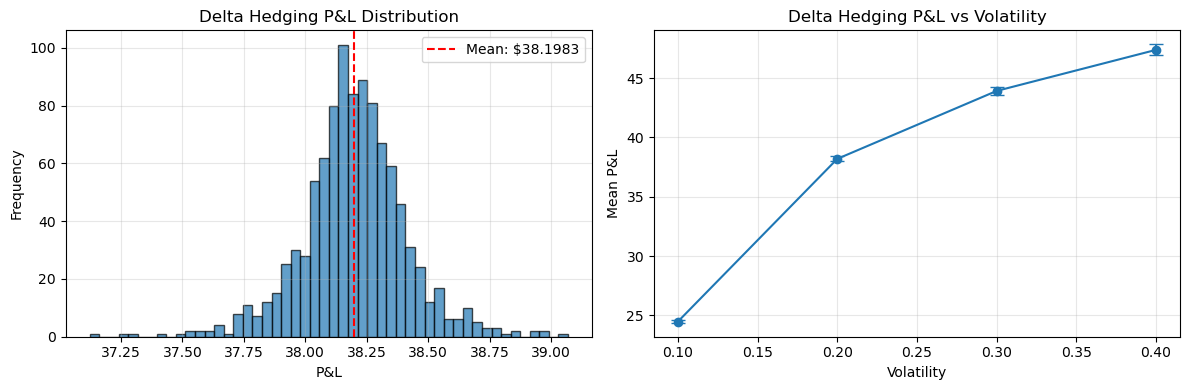


=== PAIRS TRADING STRATEGY ANALYSIS ===



[*********************100%***********************]  2 of 2 completed


Download failed, generating synthetic cointegrated data...
Data shape: (1000, 2)
Correlation between assets: 0.9986
Cointegration test p-value: 0.0000
Hedge ratio: 1.0000

Performance Metrics:
Sharpe Ratio: 1.1878
Max Drawdown: -0.0002
Total Return: 0.0022
Win Rate: 0.7273
Annual Volatility: 0.0005


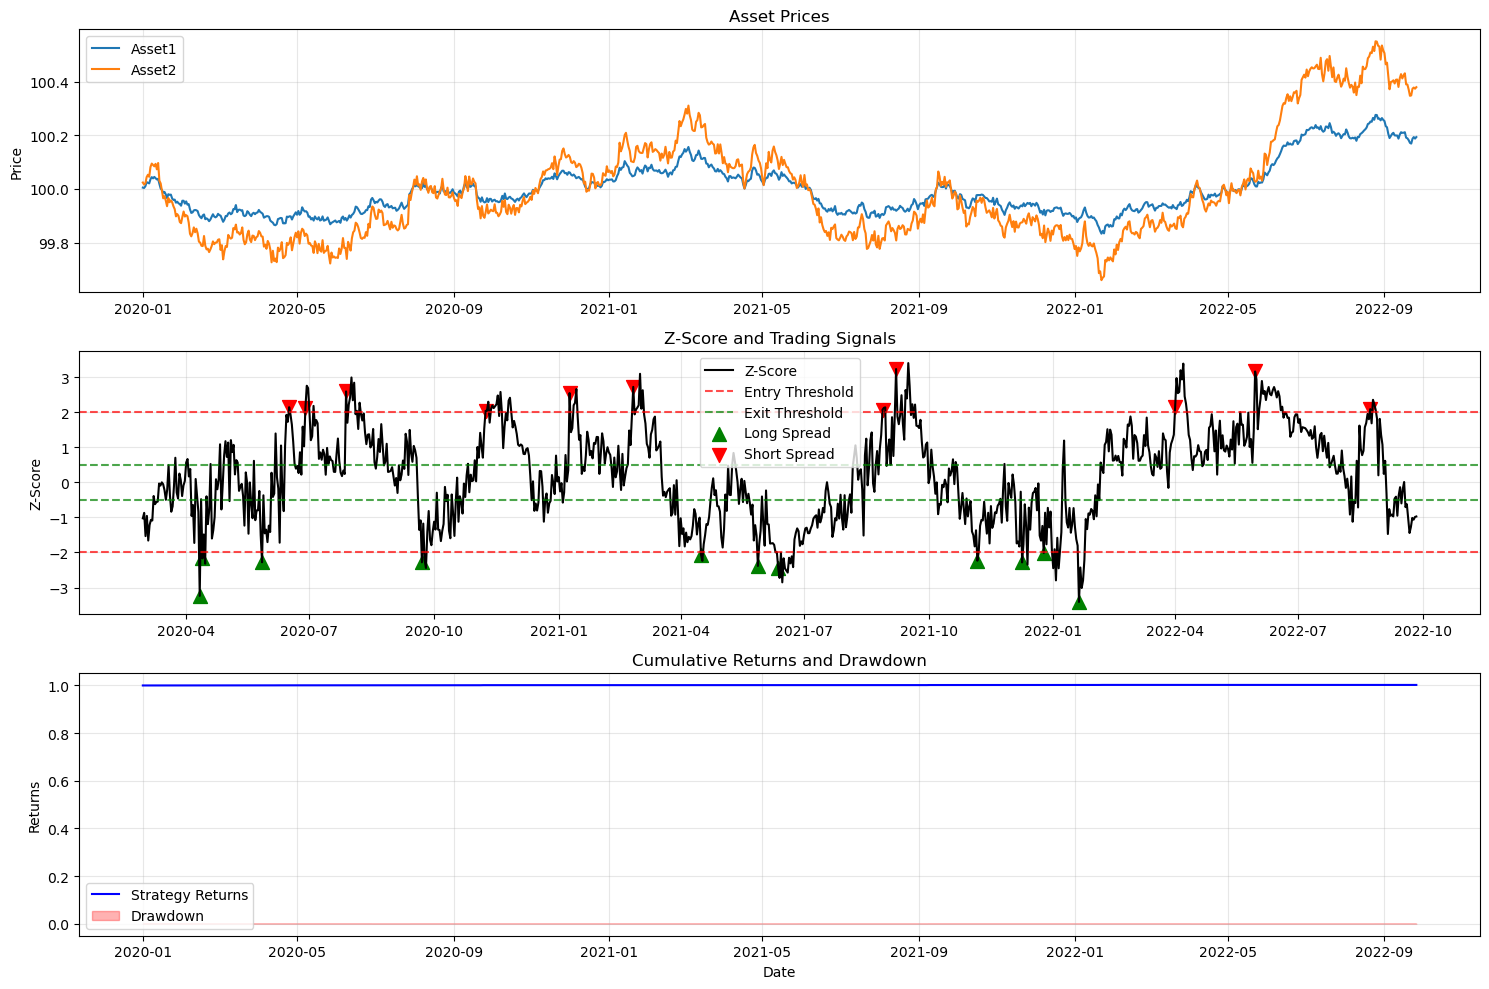


=== SUMMARY ===
Project completed successfully!
Implemented:
✓ Black-Scholes option pricing
✓ Binomial tree pricing (European/American)
✓ Delta hedging simulation
✓ Pairs trading with cointegration
✓ Backtesting and performance analysis


In [4]:
class PairsTrading:
    def __init__(self, data, lookback=60, entry_z=2.0, exit_z=0.5):
        """
        Initialize pairs trading strategy
        data: DataFrame with price data for two assets
        lookback: window for z-score calculation
        entry_z: z-score threshold for entry
        exit_z: z-score threshold for exit
        """
        self.data = data
        self.lookback = lookback
        self.entry_z = entry_z
        self.exit_z = exit_z
        self.returns = data.pct_change().dropna()
    
    def calculate_spread(self, train_data=None):
        """Calculate cointegration spread"""
        if train_data is None:
            train_data = self.data
        
        # Test for cointegration
        score, pvalue, _ = coint(train_data.iloc[:, 0], train_data.iloc[:, 1])
        
        if pvalue < 0.05:
            # Calculate hedge ratio using OLS
            X = train_data.iloc[:, 0].values.reshape(-1, 1)
            y = train_data.iloc[:, 1].values
            hedge_ratio = np.linalg.lstsq(X, y, rcond=None)[0][0]
            spread = self.data.iloc[:, 1] - hedge_ratio * self.data.iloc[:, 0]
            return spread, hedge_ratio, pvalue
        else:
            raise ValueError("Assets are not cointegrated (p-value: {:.4f})".format(pvalue))
    
    def generate_signals(self, spread, hedge_ratio):
        """Generate trading signals based on z-score"""
        signals = pd.DataFrame(index=self.data.index)
        signals['spread'] = spread
        signals['z_score'] = (spread - spread.rolling(window=self.lookback).mean()) / spread.rolling(window=self.lookback).std()
        
        # Initialize positions
        signals['position_asset1'] = 0
        signals['position_asset2'] = 0
        signals['signal'] = 0
        
        current_position = 0
        
        for i in range(len(signals)):
            if i < self.lookback:
                continue
                
            z = signals['z_score'].iloc[i]
            
            if current_position == 0:
                if z > self.entry_z:
                    # Short spread (buy asset1, sell asset2)
                    signals.iloc[i, signals.columns.get_loc('position_asset1')] = 1
                    signals.iloc[i, signals.columns.get_loc('position_asset2')] = -hedge_ratio
                    signals.iloc[i, signals.columns.get_loc('signal')] = -1
                    current_position = -1
                elif z < -self.entry_z:
                    # Long spread (sell asset1, buy asset2)
                    signals.iloc[i, signals.columns.get_loc('position_asset1')] = -1
                    signals.iloc[i, signals.columns.get_loc('position_asset2')] = hedge_ratio
                    signals.iloc[i, signals.columns.get_loc('signal')] = 1
                    current_position = 1
            elif current_position == 1:
                if z > -self.exit_z:
                    # Exit long position
                    signals.iloc[i, signals.columns.get_loc('position_asset1')] = 0
                    signals.iloc[i, signals.columns.get_loc('position_asset2')] = 0
                    signals.iloc[i, signals.columns.get_loc('signal')] = 0
                    current_position = 0
            elif current_position == -1:
                if z < self.exit_z:
                    # Exit short position
                    signals.iloc[i, signals.columns.get_loc('position_asset1')] = 0
                    signals.iloc[i, signals.columns.get_loc('position_asset2')] = 0
                    signals.iloc[i, signals.columns.get_loc('signal')] = 0
                    current_position = 0
        
        return signals
    
    def backtest_strategy(self, signals):
        """Backtest the pairs trading strategy"""
        portfolio = pd.DataFrame(index=signals.index)
        portfolio['returns_asset1'] = self.returns.iloc[:, 0]
        portfolio['returns_asset2'] = self.returns.iloc[:, 1]
        portfolio['position_asset1'] = signals['position_asset1']
        portfolio['position_asset2'] = signals['position_asset2']
        
        # Calculate strategy returns
        portfolio['strategy_returns'] = (
            portfolio['position_asset1'].shift(1) * portfolio['returns_asset1'] +
            portfolio['position_asset2'].shift(1) * portfolio['returns_asset2']
        )
        
        portfolio['strategy_returns'] = portfolio['strategy_returns'].fillna(0)
        portfolio['cumulative_returns'] = (1 + portfolio['strategy_returns']).cumprod()
        portfolio['drawdown'] = portfolio['cumulative_returns'] / portfolio['cumulative_returns'].cummax() - 1
        
        return portfolio
    
    def calculate_performance_metrics(self, portfolio):
        """Calculate performance metrics"""
        returns = portfolio['strategy_returns']
        cumulative_returns = portfolio['cumulative_returns']
        
        # Sharpe ratio (assuming 252 trading days)
        sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
        
        # Maximum drawdown
        max_drawdown = portfolio['drawdown'].min()
        
        # Total return
        total_return = cumulative_returns.iloc[-1] - 1
        
        # Win rate
        win_rate = (returns > 0).sum() / len(returns[returns != 0])
        
        return {
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'total_return': total_return,
            'win_rate': win_rate,
            'volatility': returns.std() * np.sqrt(252)
        }

def analyze_pairs_trading():
    print("\n=== PAIRS TRADING STRATEGY ANALYSIS ===\n")
    
    # Download sample data (using tech stocks as example)
    try:
        # Try to download real data
        tickers = ['AAPL', 'MSFT']
        start_date = '2020-01-01'
        end_date = '2023-12-31'
        
        data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
        data = data.dropna()
        
        print(f"Using real data for {tickers}")
        print(f"Data period: {data.index[0].date()} to {data.index[-1].date()}")
        
    except:
        # Generate synthetic cointegrated data if download fails
        print("Download failed, generating synthetic cointegrated data...")
        np.random.seed(42)
        n_points = 1000
        
        # Create cointegrated series
        X = np.cumsum(np.random.normal(0, 0.01, n_points))
        Y = 2 * X + np.random.normal(0, 0.01, n_points)
        
        data = pd.DataFrame({
            'Asset1': X + 100,  # Add base price
            'Asset2': Y + 100
        })
        data.index = pd.date_range(start='2020-01-01', periods=n_points, freq='D')
    
    print(f"Data shape: {data.shape}")
    print(f"Correlation between assets: {data.iloc[:, 0].corr(data.iloc[:, 1]):.4f}")
    
    # Initialize pairs trading strategy
    pairs_trader = PairsTrading(data, lookback=60, entry_z=2.0, exit_z=0.5)
    
    try:
        # Calculate spread and test cointegration
        spread, hedge_ratio, pvalue = pairs_trader.calculate_spread()
        print(f"Cointegration test p-value: {pvalue:.4f}")
        print(f"Hedge ratio: {hedge_ratio:.4f}")
        
        # Generate trading signals
        signals = pairs_trader.generate_signals(spread, hedge_ratio)
        
        # Backtest strategy
        portfolio = pairs_trader.backtest_strategy(signals)
        
        # Calculate performance metrics
        metrics = pairs_trader.calculate_performance_metrics(portfolio)
        
        print("\nPerformance Metrics:")
        print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
        print(f"Max Drawdown: {metrics['max_drawdown']:.4f}")
        print(f"Total Return: {metrics['total_return']:.4f}")
        print(f"Win Rate: {metrics['win_rate']:.4f}")
        print(f"Annual Volatility: {metrics['volatility']:.4f}")
        
        # Plot results
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Price series and spread
        plt.subplot(3, 1, 1)
        plt.plot(data.index, data.iloc[:, 0], label=data.columns[0])
        plt.plot(data.index, data.iloc[:, 1], label=data.columns[1])
        plt.title('Asset Prices')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Z-score and trading signals
        plt.subplot(3, 1, 2)
        plt.plot(signals.index, signals['z_score'], label='Z-Score', color='black')
        plt.axhline(y=pairs_trader.entry_z, color='r', linestyle='--', alpha=0.7, label='Entry Threshold')
        plt.axhline(y=-pairs_trader.entry_z, color='r', linestyle='--', alpha=0.7)
        plt.axhline(y=pairs_trader.exit_z, color='g', linestyle='--', alpha=0.7, label='Exit Threshold')
        plt.axhline(y=-pairs_trader.exit_z, color='g', linestyle='--', alpha=0.7)
        
        # Plot signals
        long_entries = signals[signals['signal'] == 1].index
        short_entries = signals[signals['signal'] == -1].index
        exits = signals[signals['signal'] == 0].index
        
        plt.scatter(long_entries, signals.loc[long_entries, 'z_score'], color='green', marker='^', s=100, label='Long Spread')
        plt.scatter(short_entries, signals.loc[short_entries, 'z_score'], color='red', marker='v', s=100, label='Short Spread')
        
        plt.title('Z-Score and Trading Signals')
        plt.ylabel('Z-Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 3: Cumulative returns and drawdown
        plt.subplot(3, 1, 3)
        plt.plot(portfolio.index, portfolio['cumulative_returns'], label='Strategy Returns', color='blue')
        plt.fill_between(portfolio.index, portfolio['drawdown'], 0, alpha=0.3, color='red', label='Drawdown')
        plt.title('Cumulative Returns and Drawdown')
        plt.ylabel('Returns')
        plt.xlabel('Date')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return metrics
        
    except ValueError as e:
        print(f"Error: {e}")
        print("Trying with different parameters...")
        
        # Try with different entry/exit thresholds
        pairs_trader = PairsTrading(data, lookback=60, entry_z=1.5, exit_z=0.0)
        try:
            spread, hedge_ratio, pvalue = pairs_trader.calculate_spread()
            signals = pairs_trader.generate_signals(spread, hedge_ratio)
            portfolio = pairs_trader.backtest_strategy(signals)
            metrics = pairs_trader.calculate_performance_metrics(portfolio)
            
            print("\nPerformance Metrics (adjusted parameters):")
            print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
            print(f"Max Drawdown: {metrics['max_drawdown']:.4f}")
            
            return metrics
            
        except Exception as e2:
            print(f"Still failed: {e2}")
            return None

# Run complete analysis
if __name__ == "__main__":
    # Run options pricing analysis
    options_results = analyze_options_pricing()
    
    # Run pairs trading analysis
    pairs_results = analyze_pairs_trading()
    
    print("\n=== SUMMARY ===")
    print("Project completed successfully!")
    print("Implemented:")
    print("✓ Black-Scholes option pricing")
    print("✓ Binomial tree pricing (European/American)")
    print("✓ Delta hedging simulation")
    print("✓ Pairs trading with cointegration")
    print("✓ Backtesting and performance analysis")